# Mock Photon Propagation - Evaluation

This notebook should give us an overview of the geometric properties of the mock photon propagation. With this we want to evaluate rightful behaviour. To do that we will leave the Olympus way of doing things with event generators and the detector builder. Instead, we will "Mock" our detector to accompany our specific needs!

## Let us import everything first

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ananke.configurations.detector import DetectorConfiguration
from ananke.models.detector import Detector
from ananke.models.geometry import Vectors3D
from ananke.models.event import EventRecords, Sources
from ananke.schemas.detector import DetectorSchema
from olympus.event_generation.generators import GeneratorCollection, GeneratorFactory
from olympus.event_generation.medium import MediumEstimationVariant, Medium
from olympus.event_generation.photon_propagation.mock_photons import MockPhotonPropagator

import jax
import jax.numpy as jnp

# Global flag to set a specific platform, must be used at startup.
# jax.config.update('jax_platform_name', 'cpu')

## Build Mock Detector

To evaluate the mock photon propagation, we want to build a mock detector. This detector will contain different modules with specific pmt locations and distances. Specifically, we will look at following modules:

* PMT To Cherenkov orientation: Rotate the PMT along the direction of the source (0 / 180)
* PMT To Source rotation: Precession of PMTs against pmt to source direction
* PMT Distances: PMTs at specific distances

To see how we can construct our own detector we can have a look at the Detector DataFrame Schema.

In [2]:
print(DetectorSchema.to_schema())

<Schema DataFrameSchema(
    columns={
        'pmt_id': <Schema Column(name=pmt_id, type=DataType(int64))>
        'pmt_efficiency': <Schema Column(name=pmt_efficiency, type=DataType(float64))>
        'pmt_area': <Schema Column(name=pmt_area, type=DataType(float64))>
        'pmt_noise_rate': <Schema Column(name=pmt_noise_rate, type=DataType(float64))>
        'pmt_location_x': <Schema Column(name=pmt_location_x, type=DataType(float64))>
        'pmt_location_y': <Schema Column(name=pmt_location_y, type=DataType(float64))>
        'pmt_location_z': <Schema Column(name=pmt_location_z, type=DataType(float64))>
        'pmt_orientation_x': <Schema Column(name=pmt_orientation_x, type=DataType(float64))>
        'pmt_orientation_y': <Schema Column(name=pmt_orientation_y, type=DataType(float64))>
        'pmt_orientation_z': <Schema Column(name=pmt_orientation_z, type=DataType(float64))>
        'module_id': <Schema Column(name=module_id, type=DataType(int64))>
        'module_radius': <Sc

First, let's define some constants for the detector:

In [3]:
dark_noise_rate = 16 * 1e-5  # 1/ns
pmt_cath_area_r = 75e-3 / 2  # m
module_radius = 0.21  # m
efficiency = 0.42 # Christian S. Number
number_of_angles = 18

Okay let's get startet with the module for the cherenkov. For that we will assume that the source is heading along the z-axis. and is positioned on the x-axis. Hence, we will rotate one PMT along the xz-plane starting with the direction of the z-axis.

In [4]:
spherical_orientations = np.zeros((number_of_angles, 3))

spherical_orientations[:, 0] = 1
module_1_angle_range = np.linspace(0, -1* np.pi, number_of_angles)
spherical_orientations[:, 2] = module_1_angle_range
spherical_orientations_df = pd.DataFrame(spherical_orientations, columns=('norm', 'phi', 'theta'))
cartesian_orientations = Vectors3D.from_spherical(spherical_orientations_df)

module_1_df = cartesian_orientations.get_df_with_prefix('pmt_orientation_')
module_1_df['pmt_id'] = range(number_of_angles)
module_1_df['pmt_efficiency'] = efficiency
module_1_df['pmt_area'] = pmt_cath_area_r
module_1_df['pmt_noise_rate'] = dark_noise_rate
module_1_df['pmt_location_x'] = 0.0
module_1_df['pmt_location_y'] = 0.0
module_1_df['pmt_location_z'] = 0.0
module_1_df['module_id'] = 0
module_1_df['module_radius'] = module_radius
module_1_df['module_location_x'] = 0.0
module_1_df['module_location_y'] = 0.0
module_1_df['module_location_z'] = 0.0
module_1_df['string_id'] = 0
module_1_df['string_location_x'] = 0.0
module_1_df['string_location_y'] = 0.0
module_1_df['string_location_z'] = 0.0

module_1_detector = Detector(df=module_1_df)
module_1_detector.df.head()

,pmt_orientation_x,pmt_orientation_y,pmt_orientation_z,pmt_id,pmt_efficiency,pmt_area,pmt_noise_rate,pmt_location_x,pmt_location_y,pmt_location_z,module_id,module_radius,module_location_x,module_location_y,module_location_z,string_id,string_location_x,string_location_y,string_location_z
0,0.000000,0.0,1.000000,0,0.42,0.0375,0.00016,0.0,0.0,0.0,0,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
1,-0.183750,-0.0,0.982973,1,0.42,0.0375,0.00016,0.0,0.0,0.0,0,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
2,-0.361242,-0.0,0.932472,2,0.42,0.0375,0.00016,0.0,0.0,0.0,0,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
3,-0.526432,-0.0,0.850217,3,0.42,0.0375,0.00016,0.0,0.0,0.0,0,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
4,-0.673696,-0.0,0.739009,4,0.42,0.0375,0.00016,0.0,0.0,0.0,0,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0


Now let's define the precession pmt. We start with the PMT directly facing the source and rotate it around the xy-plane

In [5]:
spherical_orientations = np.zeros((number_of_angles, 3))

spherical_orientations[:, 0] = 1
module_2_angle_range = np.linspace(0, 2*np.pi, number_of_angles)
spherical_orientations[:, 1] = module_2_angle_range
spherical_orientations[:, 2] = np.pi / 2
spherical_orientations_df = pd.DataFrame(spherical_orientations, columns=('norm', 'phi', 'theta'))
cartesian_orientations = Vectors3D.from_spherical(spherical_orientations_df)

module_2_df = cartesian_orientations.get_df_with_prefix('pmt_orientation_')
module_2_df['pmt_id'] = range(number_of_angles)
module_2_df['pmt_efficiency'] = efficiency
module_2_df['pmt_area'] = pmt_cath_area_r
module_2_df['pmt_noise_rate'] = dark_noise_rate
module_2_df['pmt_location_x'] = 0.0
module_2_df['pmt_location_y'] = 0.0
module_2_df['pmt_location_z'] = 0.0
module_2_df['module_id'] = 1
module_2_df['module_radius'] = module_radius
module_2_df['module_location_x'] = 0.0
module_2_df['module_location_y'] = 0.0
module_2_df['module_location_z'] = 0.0
module_2_df['string_id'] = 0
module_2_df['string_location_x'] = 0.0
module_2_df['string_location_y'] = 0.0
module_2_df['string_location_z'] = 0.0

module_2_detector = Detector(df=module_2_df)
module_2_detector.df.head()

,pmt_orientation_x,pmt_orientation_y,pmt_orientation_z,pmt_id,pmt_efficiency,pmt_area,pmt_noise_rate,pmt_location_x,pmt_location_y,pmt_location_z,module_id,module_radius,module_location_x,module_location_y,module_location_z,string_id,string_location_x,string_location_y,string_location_z
0,1.000000,0.000000,6.123234e-17,0,0.42,0.0375,0.00016,0.0,0.0,0.0,1,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
1,0.932472,0.361242,6.123234e-17,1,0.42,0.0375,0.00016,0.0,0.0,0.0,1,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
2,0.739009,0.673696,6.123234e-17,2,0.42,0.0375,0.00016,0.0,0.0,0.0,1,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
3,0.445738,0.895163,6.123234e-17,3,0.42,0.0375,0.00016,0.0,0.0,0.0,1,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
4,0.092268,0.995734,6.123234e-17,4,0.42,0.0375,0.00016,0.0,0.0,0.0,1,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0


Now, let's mix the previous cases. We start with a theta of 45° and rotate phi 360°

In [6]:
spherical_orientations = np.zeros((number_of_angles, 3))

spherical_orientations[:, 0] = 1
module_3_angle_range = np.linspace(0, 2*np.pi, number_of_angles)
spherical_orientations[:, 1] = module_3_angle_range
spherical_orientations[:, 2] = np.pi / 4
spherical_orientations_df = pd.DataFrame(spherical_orientations, columns=('norm', 'phi', 'theta'))
cartesian_orientations = Vectors3D.from_spherical(spherical_orientations_df)

module_3_df = cartesian_orientations.get_df_with_prefix('pmt_orientation_')
module_3_df['pmt_id'] = range(number_of_angles)
module_3_df['pmt_efficiency'] = efficiency
module_3_df['pmt_area'] = pmt_cath_area_r
module_3_df['pmt_noise_rate'] = dark_noise_rate
module_3_df['pmt_location_x'] = 0.0
module_3_df['pmt_location_y'] = 0.0
module_3_df['pmt_location_z'] = 0.0
module_3_df['module_id'] = 2
module_3_df['module_radius'] = module_radius
module_3_df['module_location_x'] = 0.0
module_3_df['module_location_y'] = 0.0
module_3_df['module_location_z'] = 0.0
module_3_df['string_id'] = 0
module_3_df['string_location_x'] = 0.0
module_3_df['string_location_y'] = 0.0
module_3_df['string_location_z'] = 0.0

module_3_detector = Detector(df=module_3_df)
module_3_detector.df.head()

,pmt_orientation_x,pmt_orientation_y,pmt_orientation_z,pmt_id,pmt_efficiency,pmt_area,pmt_noise_rate,pmt_location_x,pmt_location_y,pmt_location_z,module_id,module_radius,module_location_x,module_location_y,module_location_z,string_id,string_location_x,string_location_y,string_location_z
0,0.707107,0.000000,0.707107,0,0.42,0.0375,0.00016,0.0,0.0,0.0,2,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
1,0.659357,0.255436,0.707107,1,0.42,0.0375,0.00016,0.0,0.0,0.0,2,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
2,0.522558,0.476375,0.707107,2,0.42,0.0375,0.00016,0.0,0.0,0.0,2,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
3,0.315185,0.632976,0.707107,3,0.42,0.0375,0.00016,0.0,0.0,0.0,2,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
4,0.065244,0.704090,0.707107,4,0.42,0.0375,0.00016,0.0,0.0,0.0,2,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0


Last, but not least we are varying the distance of the PMTs with the PMTs heading directly towards the source on the x-axis facing the z-direction.

In [7]:
distance_between_pmts = 5
maximum_distance = 100
number_of_steps = int(maximum_distance / distance_between_pmts)
module_4_range = np.arange(0, maximum_distance, distance_between_pmts)
cartesian_locations = np.zeros((number_of_steps, 3))
cartesian_locations[:, 0] = module_4_range
cartesian_locations = Vectors3D.from_numpy(cartesian_locations)

module_4_df = cartesian_locations.get_df_with_prefix('pmt_location_')
module_4_df['pmt_id'] = range(number_of_steps)
module_4_df['pmt_efficiency'] = efficiency
module_4_df['pmt_area'] = pmt_cath_area_r
module_4_df['pmt_noise_rate'] = dark_noise_rate
module_4_df['pmt_orientation_x'] = -1.0
module_4_df['pmt_orientation_y'] = 0.0
module_4_df['pmt_orientation_z'] = 0.0
module_4_df['module_id'] = 3
module_4_df['module_radius'] = module_radius
module_4_df['module_location_x'] = 0.0
module_4_df['module_location_y'] = 0.0
module_4_df['module_location_z'] = 0.0
module_4_df['string_id'] = 0
module_4_df['string_location_x'] = 0.0
module_4_df['string_location_y'] = 0.0
module_4_df['string_location_z'] = 0.0

module_4_detector = Detector(df=module_4_df)
module_4_detector.df.head()

,pmt_location_x,pmt_location_y,pmt_location_z,pmt_id,pmt_efficiency,pmt_area,pmt_noise_rate,pmt_orientation_x,pmt_orientation_y,pmt_orientation_z,module_id,module_radius,module_location_x,module_location_y,module_location_z,string_id,string_location_x,string_location_y,string_location_z
0,0.0,0.0,0.0,0,0.42,0.0375,0.00016,-1.0,0.0,0.0,3,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
1,5.0,0.0,0.0,1,0.42,0.0375,0.00016,-1.0,0.0,0.0,3,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
2,10.0,0.0,0.0,2,0.42,0.0375,0.00016,-1.0,0.0,0.0,3,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
3,15.0,0.0,0.0,3,0.42,0.0375,0.00016,-1.0,0.0,0.0,3,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0
4,20.0,0.0,0.0,4,0.42,0.0375,0.00016,-1.0,0.0,0.0,3,0.21,0.0,0.0,0.0,0,0.0,0.0,0.0


Let's complete our detector:

In [8]:
detector = Detector.concat([
    module_1_detector,
    module_2_detector,
    module_3_detector,
    module_4_detector,
])
len(detector.df.index)

74

## Build Mock Event and Sources

After the detector, we only need to create an event and its sources. Here as well to be able to evaluate the cherenkov dependency we create events and sources starting in y-axis direction and then rotating down the xz-plane

In [9]:
spherical_orientations = np.zeros((number_of_angles, 3))

spherical_orientations[:, 0] = 1
source_angle_range = np.linspace(0, np.pi, number_of_angles)
spherical_orientations[:, 2] = source_angle_range
spherical_orientations_df = pd.DataFrame(spherical_orientations, columns=('norm', 'phi', 'theta'))
cartesian_orientations = Vectors3D.from_spherical(spherical_orientations_df)

events_df = cartesian_orientations.get_df_with_prefix('orientation_')
events_df['record_id'] = range(number_of_angles)
events_df['time'] = 0.0
events_df['location_x'] = -5.0
events_df['location_y'] = 0.0
events_df['location_z'] = 0.0

sources_df = events_df.copy()

events_df['energy'] = 10000
events_df['length'] = 3000
events_df['particle_id'] = 11
events_df['type'] = 'cascade'

sources_df['type'] = 'cherenkov'
sources_df['number_of_photons'] = 100000

event_records = EventRecords(df=events_df)
sources = Sources(df=sources_df)

event_records.df.head()

,orientation_x,orientation_y,orientation_z,record_id,time,location_x,location_y,location_z,energy,length,particle_id,type
0,0.000000,0.0,1.000000,0,0.0,-5.0,0.0,0.0,10000.0,3000.0,11,cascade
1,0.183750,0.0,0.982973,1,0.0,-5.0,0.0,0.0,10000.0,3000.0,11,cascade
2,0.361242,0.0,0.932472,2,0.0,-5.0,0.0,0.0,10000.0,3000.0,11,cascade
3,0.526432,0.0,0.850217,3,0.0,-5.0,0.0,0.0,10000.0,3000.0,11,cascade
4,0.673696,0.0,0.739009,4,0.0,-5.0,0.0,0.0,10000.0,3000.0,11,cascade


In [10]:
sources.df.head()

,orientation_x,orientation_y,orientation_z,record_id,time,location_x,location_y,location_z,type,number_of_photons
0,0.000000,0.0,1.000000,0,0.0,-5.0,0.0,0.0,cherenkov,100000
1,0.183750,0.0,0.982973,1,0.0,-5.0,0.0,0.0,cherenkov,100000
2,0.361242,0.0,0.932472,2,0.0,-5.0,0.0,0.0,cherenkov,100000
3,0.526432,0.0,0.850217,3,0.0,-5.0,0.0,0.0,cherenkov,100000
4,0.673696,0.0,0.739009,4,0.0,-5.0,0.0,0.0,cherenkov,100000


## Let's propagate

Now we have the detector, the events and the sources. Time to propagate:

In [11]:
medium = Medium(MediumEstimationVariant.PONE_OPTIMISTIC)

photon_propagator = MockPhotonPropagator(
    detector=detector,
    medium=medium,
    angle_resolution=18000,
)

hits, photon_counts = photon_propagator.propagate(event_records, sources, return_photon_counts=True)

In [12]:
hits.df.loc[hits.df['record_id'] ==0.0]['time']
len(hits.df)

7746468

Faszinating. Look how many hits we generated. More interestingly, we can now evaluate the properties of the mock photon propatation.

## Evaluation of the Mock Photon Propagation

We want to evaluate the following cases

1. What happens when the PMT rotates along the cherenkov axis?
2. What happens when the PMT rotates perpendicular to the cherenkov axis?
3. What happens when the PMT rotates along both axis at an 45° angle?
4. What happens when the PMT moves further away from the source?
5. What happens when the source direction roates along the cherenkov axis?

First we will define a helper function to draw beautiful graphs. For the first three points we let the source be shining along the x axis only

In [13]:
def plot(x, y, title, x_label, show=True):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Photon Count')
    ax.set_title(title)
    if show:
        plt.show()
    

### What happens when the PMT rotates along the cherenkov axis?

In this case the angle between the PMT and the source changes from the PMT taking the same direction as the Source to facing the source directly and continuing on that plane until the PMT faces the opposite direction.

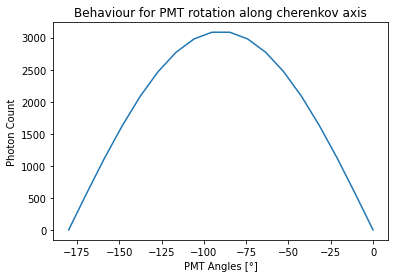

In [14]:
plot(module_1_angle_range * 180 / np.pi, photon_counts[:number_of_angles,0], 'Behaviour for PMT rotation along cherenkov axis', 'PMT Angles [°]')

### What happens when the PMT rotates perpendicular to the cherenkov axis?

Next up we check the same thing. Only that the the PMT is now facing the source directly at the beginning and moves with an angle on the plane having the source orientation as its normal vector.

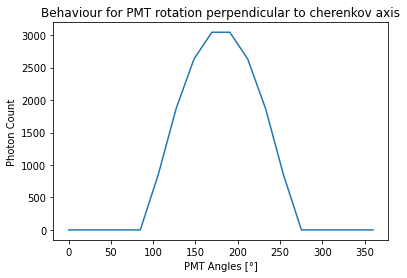

In [15]:
plot(module_2_angle_range * 180 / np.pi, photon_counts[number_of_angles:2*number_of_angles,0], 'Behaviour for PMT rotation perpendicular to cherenkov axis', 'PMT Angles [°]')

### What happens when the PMT rotates along both axis at an 45° angle?

This time, we combine the previous two methods having the PMT at an angle of 45° towards the plane having the orientation of the source as a normal.


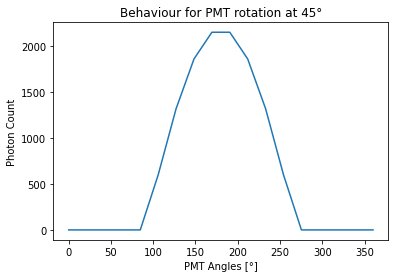

In [16]:
plot(module_3_angle_range * 180 / np.pi, photon_counts[2*number_of_angles:3*number_of_angles,0], 'Behaviour for PMT rotation at 45°', 'PMT Angles [°]')

### What happens if the source moves further away?

This time the PMT faces the source directly and moves away slowly.

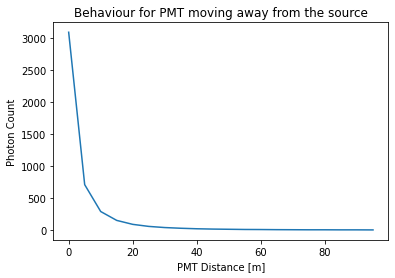

In [17]:
plot(module_4_range, photon_counts[3*number_of_angles:3*number_of_angles+number_of_steps,0], 'Behaviour for PMT moving away from the source', 'PMT Distance [m]')

### What happens if the Source rotates towards PMT?

Now we take the closest PMT of the last experiment with the PMT distance and evaluate what happens when the source first goes perpendicular to the PMT and then rotates until it faces it and back until 360° are reached

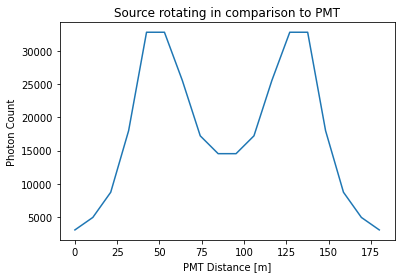

In [18]:
plot(source_angle_range * 180 / np.pi, photon_counts[3*number_of_angles,:], 'Source rotating in comparison to PMT', 'PMT Distance [m]')